In [1]:
%matplotlib inline

from pathlib import Path
import warnings
import itertools
import gc

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Boosting libraries
import lightgbm as lgb
import catboost as cb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set(palette='muted')

Let's define the seed and path

In [2]:
SEED = 7
PATH = Path('telecom_churn/')

Load the data

In [3]:
data = pd.read_csv(PATH/'Churn.csv')
print(data.shape)
data.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Understanding the data

#### Here's what each column represent
- **customerID**: Unique ID of a customer
- **gender**: Male or Female
- **SeniorCitizen**: Senior citizen or not
- **Partner**: Customer has a partner or not
- **Dependents**: Customer has dependents or not
- **tenure**: Number of months customer is using the company service
- **PhoneService**: Customer has a phone service or not
- **MultipleLines**: Customer has multiplelines or not 
- **InternetService**: Type of customer service provider
- **OnlineSecurity**: Customer has online security or not
- **OnlineBackup**: Customer has online backup or not
- **DeviceProtection**: Customer has a device protection or not
- **TechSupport**: Customer has opted for tech support or not
- **StreamingTV**: Does customer has a streaming tv or not
- **StreamingMovies**: Does customer streaming movies service
- **Contract**: The contract type of the customer
- **PaperlessBilling**: Is the billing online or offline
- **PaymentMethod**: Customer's payment method
- **MonthlyCharges**: How much is customer charges monthly
- **TotalCharges**: The total amount charged to the customer
- **Churn**: Whether customer churned or not

**CustomerID** it's just a unique identifier. Let's drop it.

In [4]:
data.drop('customerID', axis=1, inplace=True)

How much data per-class we have??

In [5]:
data['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

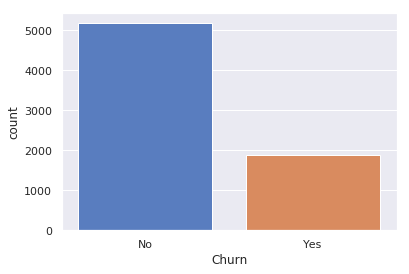

In [6]:
sns.countplot(data['Churn']);

Dataset is imbalanced. Let's binary encode the values of `Churn`

In [7]:
data['Churn'] = data['Churn'].map({'No': 0, 'Yes': 1})

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null int64
dtypes: float64(1), int64(3), object(16)
memory usage: 1.1+ MB


Why does `TotalCharges` has type `object`? Let's investigate.

In [9]:
def get_missing(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    missing = missing[missing > 0].to_frame(name='count')
    missing['percent'] = (missing['count'] / df.shape[0])*100
    return missing

In [10]:
get_missing(data)

,count,percent


In [11]:
data['TotalCharges'].value_counts(dropna=False).sort_index().head()

          11
100.2      1
100.25     1
100.35     1
100.4      1
Name: TotalCharges, dtype: int64

Look's like total values has some values = ' '. Let's make them NaN.

In [12]:
data['TotalCharges'].replace(' ', np.nan, inplace=True)
get_missing(data)

,count,percent
TotalCharges,11,0.156183


Missing values in `TotalCharges` takes up only 0.15% of dataset. Better drop these rows because we don't have any other missing values.

In [13]:
data = data[data['TotalCharges'].notnull()]
data['TotalCharges'] = data['TotalCharges'].astype(np.float32)
data.shape

(7032, 20)

There are only three `int` type columns. One of them is `Churn`. Let's investigate the other two.

In [14]:
print(f"SeniorCitizen: {data['SeniorCitizen'].nunique()}")
print(f"tenure: {data['tenure'].nunique()}")

SeniorCitizen: 2
tenure: 72


Look's like `SeniorCitizen` is just a binary feature. Let's change it's datatype to `object` just like other categorical columns

In [15]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

In [16]:
data.describe()

,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300537,0.265785
std,24.545260,30.085974,2266.771484,0.441782
min,1.000000,18.250000,18.799999,0.000000
25%,9.000000,35.587500,401.449997,0.000000
50%,29.000000,70.350000,1397.475037,0.000000
75%,55.000000,89.862500,3794.737488,1.000000
max,72.000000,118.750000,8684.799805,1.000000


Data doesn't seem to have any outliers but let's not conclude yet. Histograms and Boxplots can help us detect outliers.

In [17]:
data['MultipleLines'].value_counts()

No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64

In [18]:
data['OnlineSecurity'].value_counts()

No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64

Some of the services are dependent upon other features and have values marked as such. For eg., if there is no internet then there can't be any online security. So these are needed to be changed to `No` rather than `No internet service`.

Also, we will binary encode these features.

In [19]:
data['MultipleLines'].replace('No phone service', 'No', inplace=True)

cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in cols:
    data[col].replace('No internet service', 'No', inplace=True)
    
opted_services = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Binary encode
for col in opted_services:
    data[col] = data[col].map({'No': 0, 'Yes': 1})

Let's check for duplicate columns

In [20]:
def check_dup_cols(df):
    df_enc = pd.DataFrame(index=df.index)
    for c in df.columns: df_enc[c] = df[c].factorize()[0]
        
    dup_cols = {}
    for c1, c2 in itertools.combinations(df_enc.columns, 2):
        if c2 not in dup_cols and np.all(df_enc[c1] == df_enc[c2]): dup_cols[c1] = c2
            
    del df_enc
    return dup_cols

In [21]:
check_dup_cols(data)

{}

No duplicate colums yet.

### Data Visualization

Let's create some functions to store the boilerplate code to plot features

In [22]:
def cat_plot(data, col, hue, **kwargs):
    _, ax = plt.subplots(1, 2, **kwargs)
    sns.countplot(col, data=data, ax=ax[0])
    ax[0].set_title(f'{col} count')
    
    sns.countplot(col, data=data, hue=hue, ax=ax[1])
    ax[1].set_title(f'{col} vs {hue} count')
    
    plt.xlabel(col)
    plt.ylabel('Count')
    if data[col].nunique() > 3:
        for a in ax: a.tick_params(axis='x', rotation=45)

In [23]:
def hist_plot(data, col, hue, **kwargs):
    _, ax = plt.subplots(1, 2, **kwargs)
    sns.distplot(data[col], ax=ax[0])
    ax[0].set_title(f'{col} distribution')
    
    sns.distplot(data.loc[data[hue] == 0, col], ax=ax[1], label='No')
    sns.distplot(data.loc[data[hue] == 1, col], ax=ax[1], label='Yes')
    ax[1].set_title(f'{col} vs {hue} distribution')
    ax[1].legend()
    
    plt.xlabel(col)

In [24]:
def box_plot(data, col, hue, **kwargs):
    _, ax = plt.subplots(1, 2, **kwargs)
    sns.boxplot(data[col], ax=ax[0])
    ax[0].set_title(f'{col} distribution')
    
    sns.boxplot(x=hue, y=col, data=data, ax=ax[1])
    ax[1].set_title(f'{col} vs {hue} distribution')
    ax[1].set_xlabel(hue)

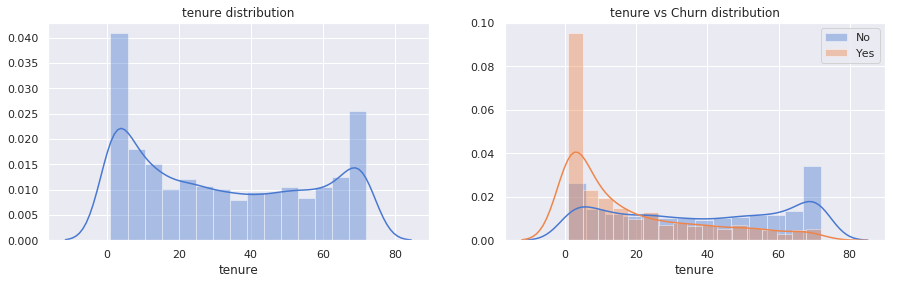

In [25]:
hist_plot(data, col='tenure', hue='Churn', figsize=(15, 4))

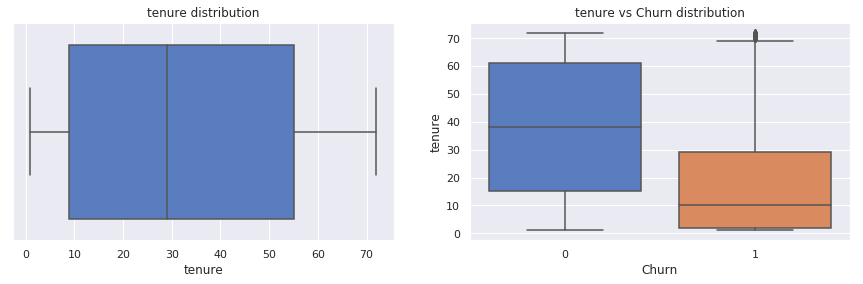

In [26]:
box_plot(data, col='tenure', hue='Churn', figsize=(15, 4))

`tenure` seems to have high `Churn` probability when it is low and low `Churn` probability when it is high. Also no outliers here.

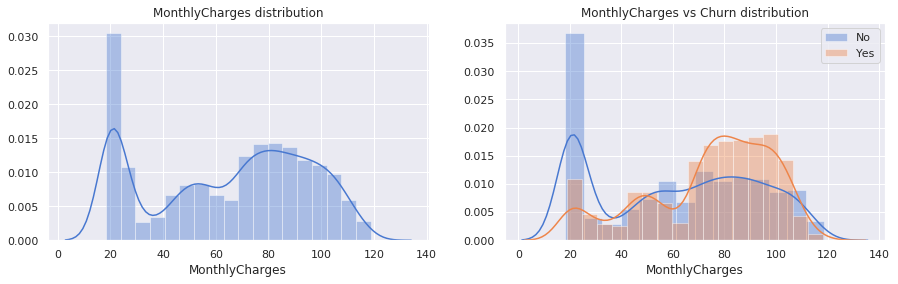

In [27]:
hist_plot(data, col='MonthlyCharges', hue='Churn', figsize=(15, 4))

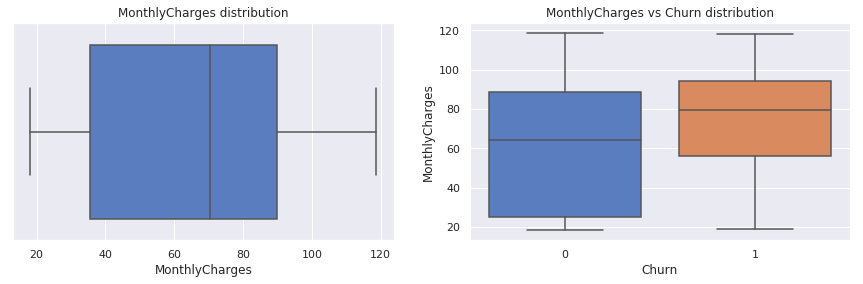

In [28]:
box_plot(data, col='MonthlyCharges', hue='Churn', figsize=(15, 4))

`MonthlyCharges` seems to have low `Churn` probability when it is low and high `Churn` probability when it is high. Also no outliers here too.

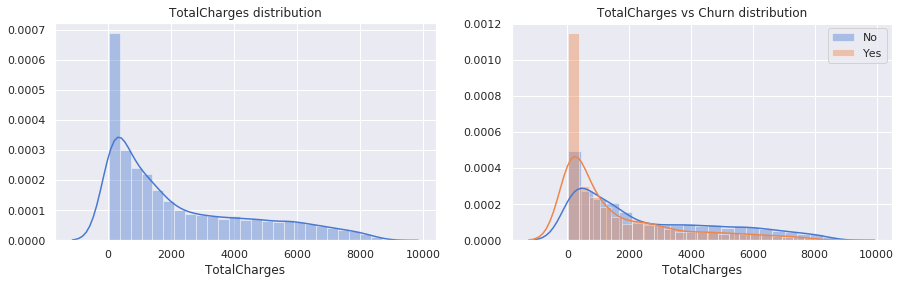

In [29]:
hist_plot(data, col='TotalCharges', hue='Churn', figsize=(15, 4))

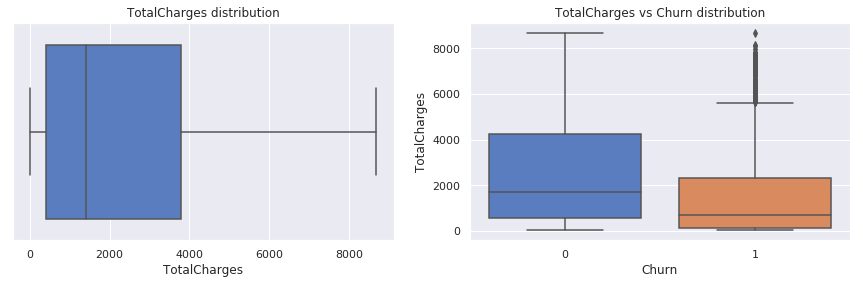

In [30]:
box_plot(data, col='TotalCharges', hue='Churn', figsize=(15, 4))

`TotalCharges` seems to have high `Churn` probability when it is high. Also no outliers here.

Let's check the distribution of services.

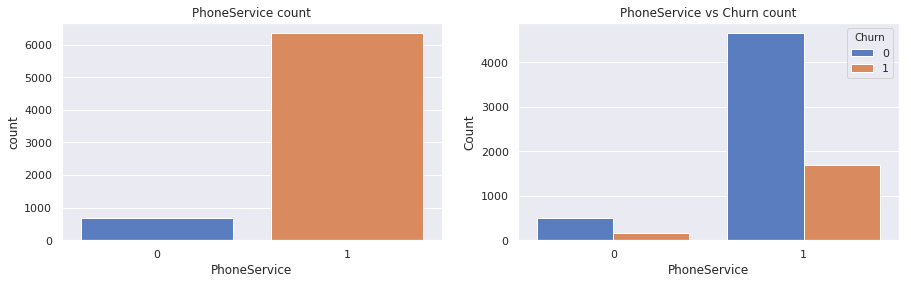

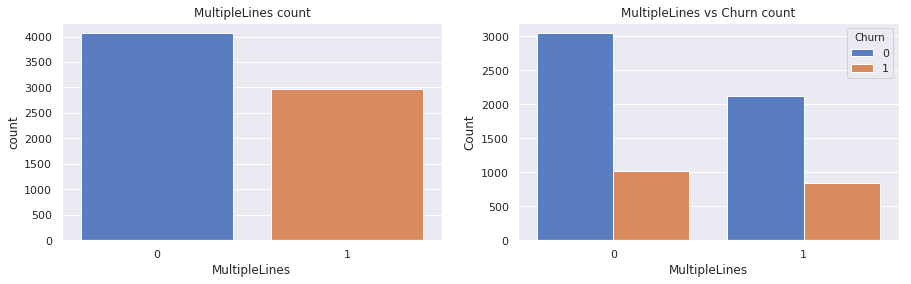

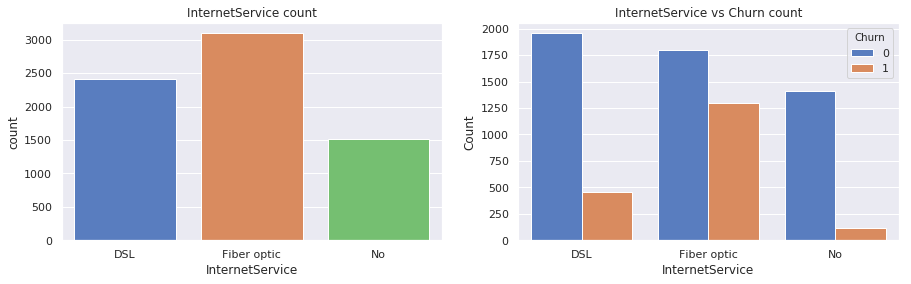

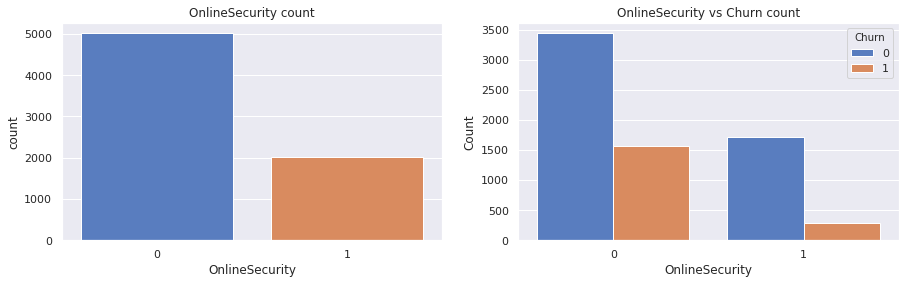

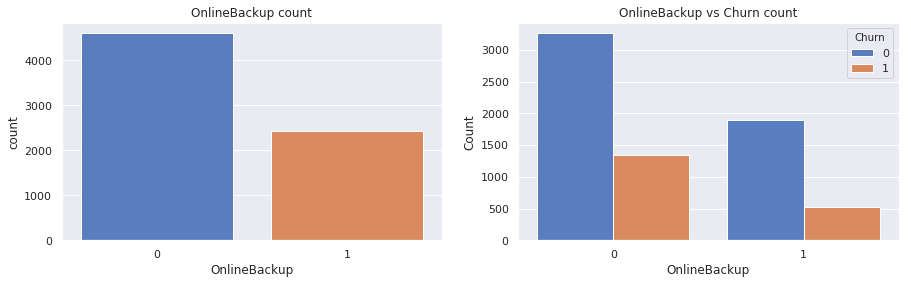

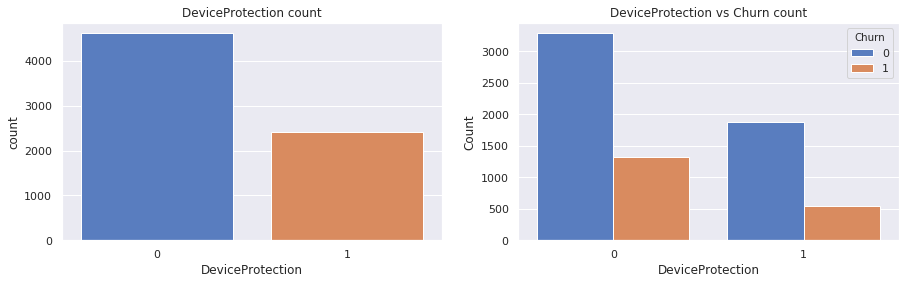

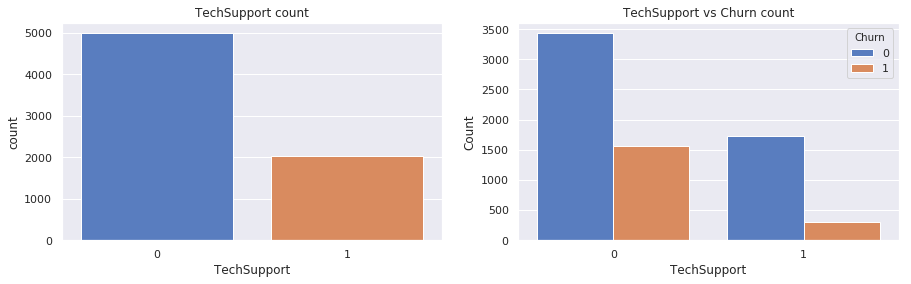

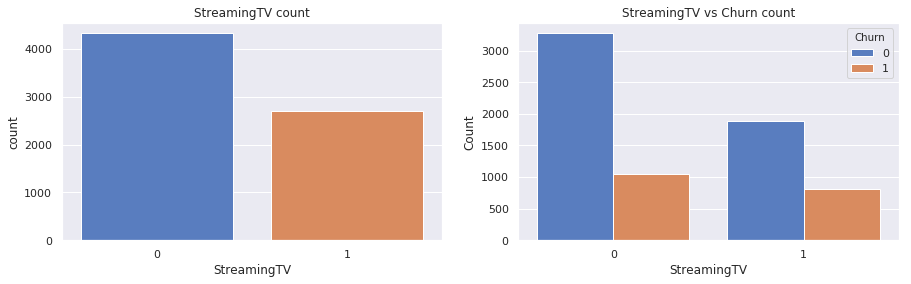

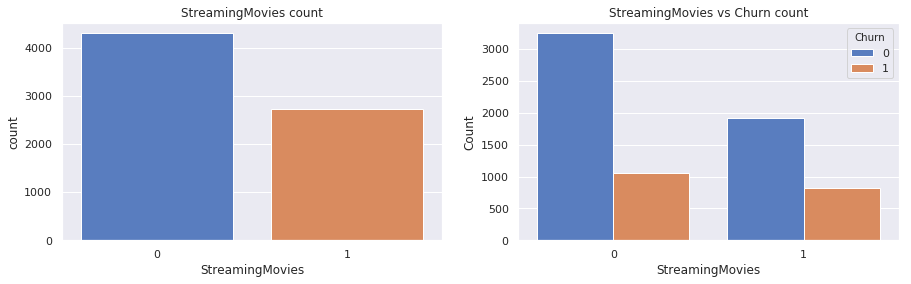

In [31]:
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in services:
    cat_plot(data, col=col, hue='Churn', figsize=(15, 4))

Conclusions from above plots:
1. Most of them have opted for phone services.
2. Customers with no internet have low probability to churn.
2. Customers with online security have low probability to churn.

Let's visualize services vs churn

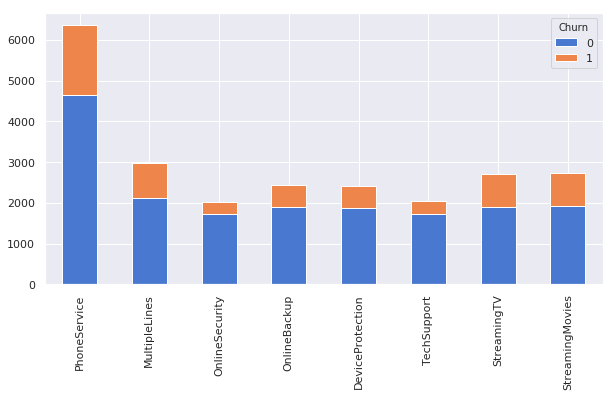

In [32]:
tmp = data.groupby('Churn')[opted_services].sum()
tmp.T.plot(kind='bar', stacked=True, figsize=(10, 5));

Not much to gain here. Let's visualize other categorical features. 

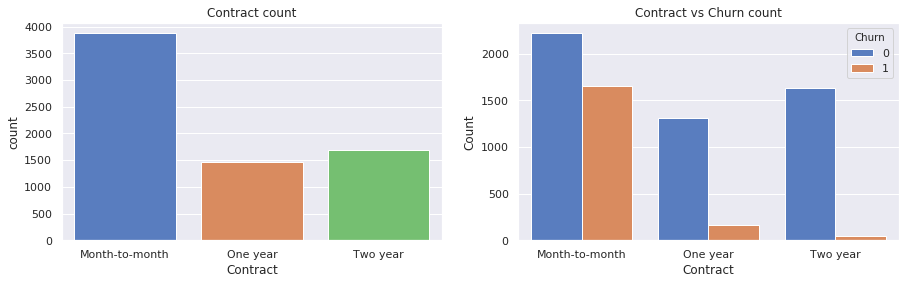

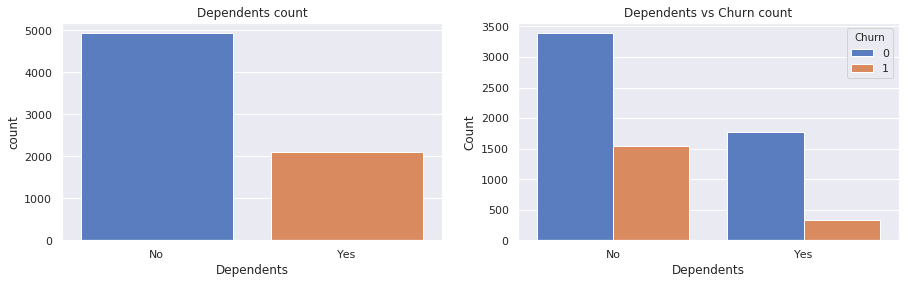

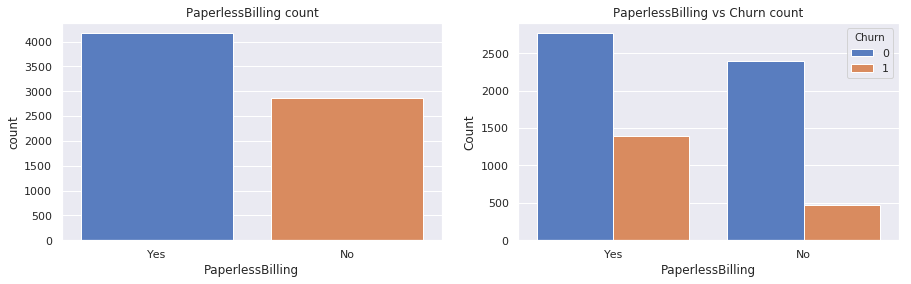

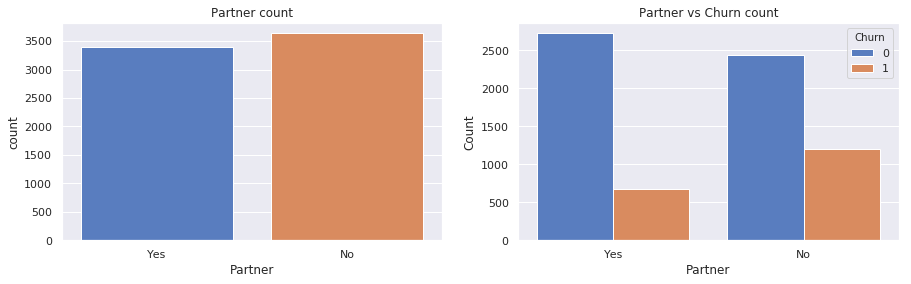

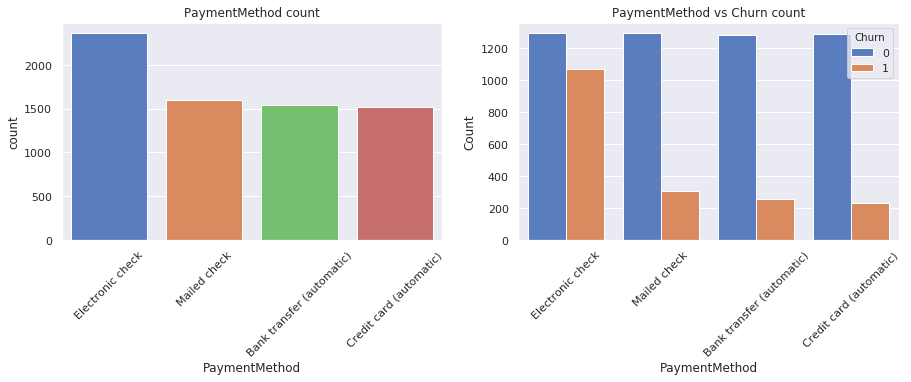

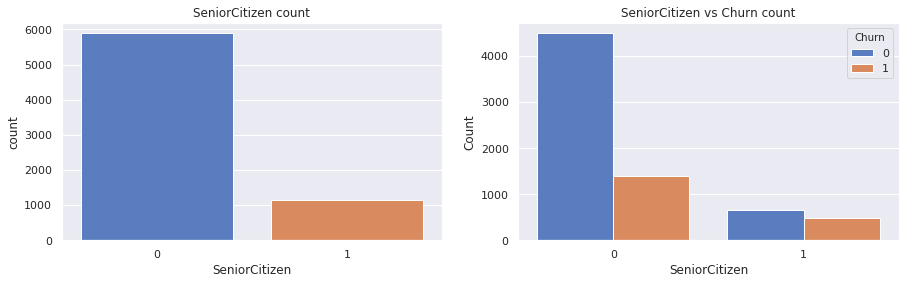

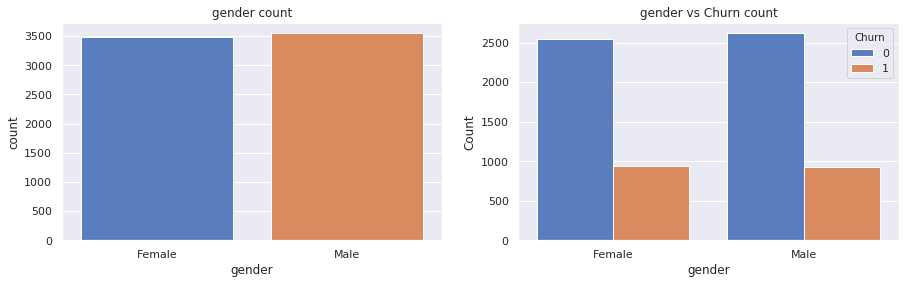

In [33]:
cols = ['Contract', 'Dependents', 'PaperlessBilling', 'Partner', 'PaymentMethod', 'SeniorCitizen', 'gender']

for col in cols:
    cat_plot(data, col=col, hue='Churn', figsize=(15, 4))

Conclusions from above plots:
1. Customers with Monthly Packages have high probability to churn.
2. Customers that pay thourgh electronic check have high probability to churn.
3. Customers with partner have comparitively low probability to churn.

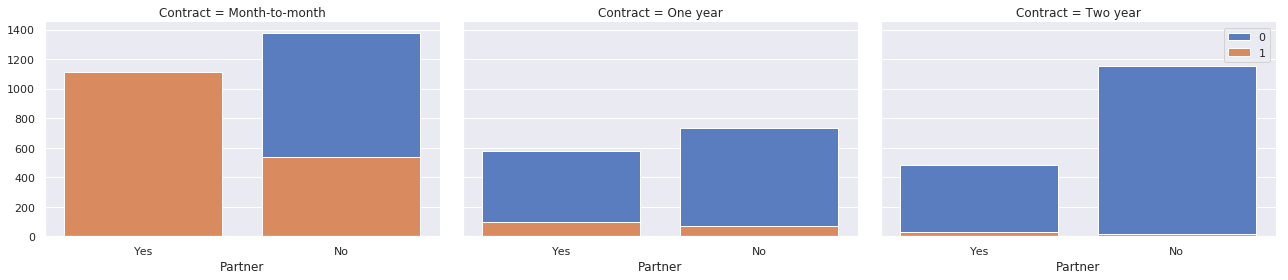

In [34]:
g = sns.FacetGrid(data, col='Contract', hue='Churn', height=4, aspect=1.5)
g.map(sns.countplot, 'Partner')
plt.legend();

Almost all with monthly plans that have partners will churn. Churn probability decreases as plan type with longer duration. It's natural as customers opted longer duration plans must have some trust in the services and therefore have low churn probability.

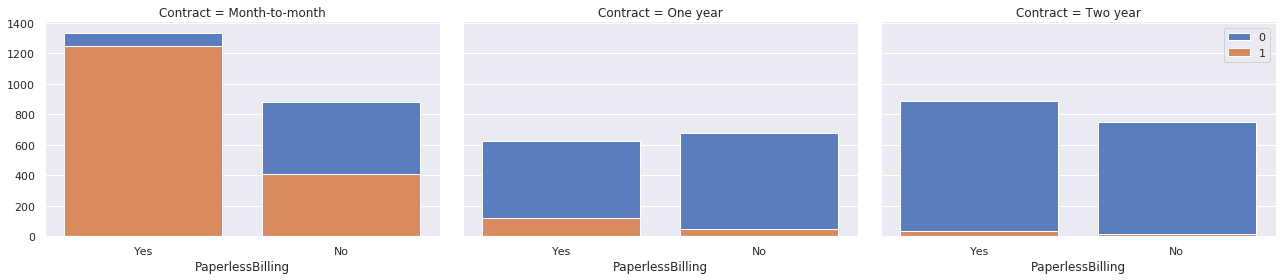

In [35]:
g = sns.FacetGrid(data, col='Contract', hue='Churn', height=4, aspect=1.5)
g.map(sns.countplot, 'PaperlessBilling')
plt.legend();

Here also we notice the same thing. Looks like `contract` is an important feature here.

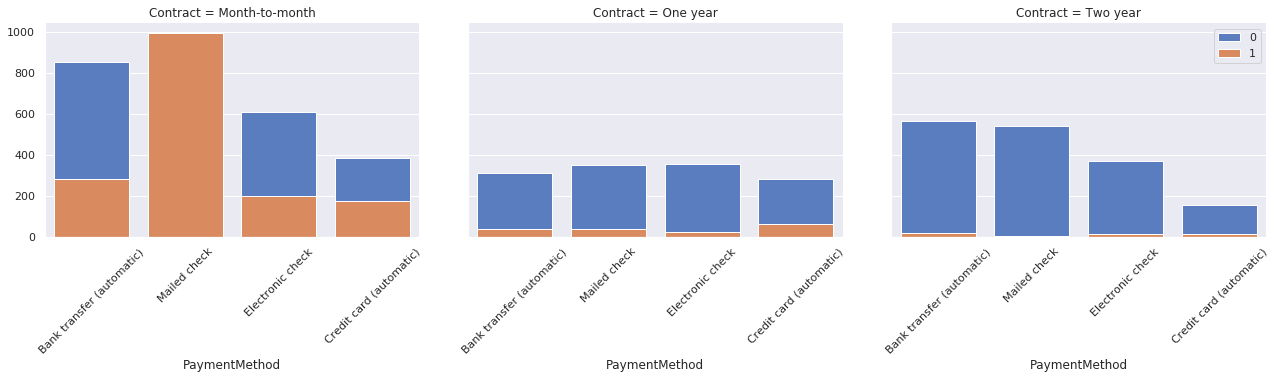

In [36]:
g = sns.FacetGrid(data, col='Contract', hue='Churn', height=4, aspect=1.5)
g.map(sns.countplot, 'PaymentMethod')

for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.legend();

Customer with monthly plan and that pay through Mailed check have high probability to churn.

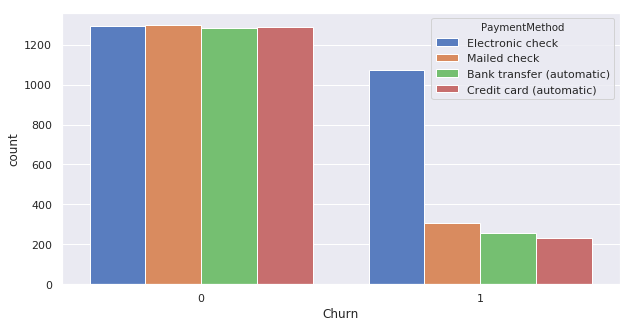

In [37]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Churn', data=data, hue='PaymentMethod');

Customer with `PaymentMethod` as Electronic Check tends to churn more as compared to other payment methods.

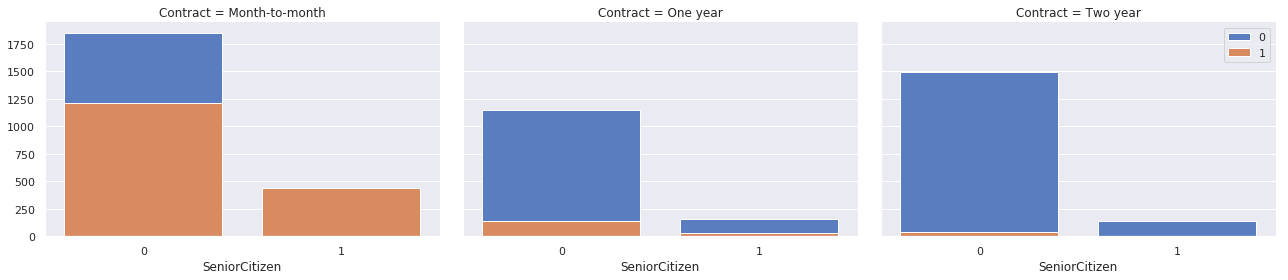

In [38]:
g = sns.FacetGrid(data, col='Contract', hue='Churn', height=4, aspect=1.5)
g.map(sns.countplot, 'SeniorCitizen')
plt.legend();

Let's see the distribution of `Partner` and `Dependents` together.

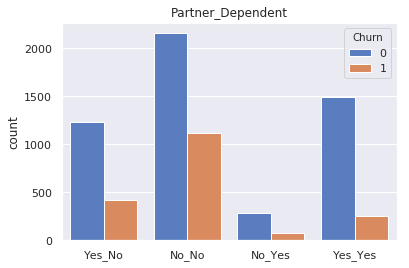

In [39]:
sns.countplot(data['Partner'] + '_' + data['Dependents'], hue=data['Churn'])
plt.title('Partner_Dependent');

Let's see the distribution of `MonthlyCharges` and `tenure` with different combinations of `gender` and `SeniorCitizen`.

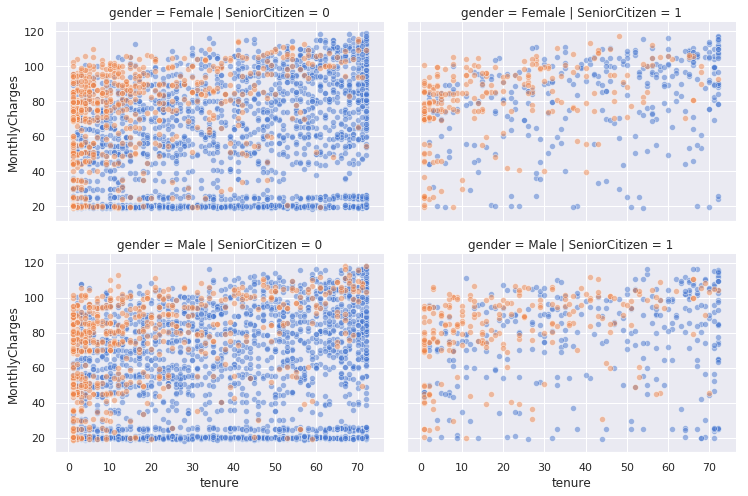

In [40]:
g = sns.FacetGrid(data, row='gender', col='SeniorCitizen', hue='Churn', height=3.5, aspect=1.5)
g.map(sns.scatterplot, 'tenure', 'MonthlyCharges', alpha=0.5);

Customer with monthly packages but with high tenure have low churn probability.

<Figure size 504x360 with 0 Axes>

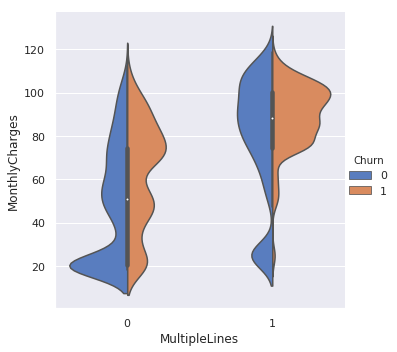

In [41]:
plt.figure(figsize=(7, 5))
sns.catplot(x='MultipleLines', y='MonthlyCharges', data=data, hue='Churn', kind='violin', split=True);

<Figure size 504x360 with 0 Axes>

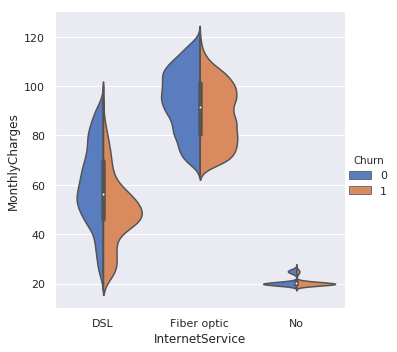

In [42]:
plt.figure(figsize=(7, 5))
sns.catplot(x='InternetService', y='MonthlyCharges', data=data, hue='Churn', kind='violin', split=True);

<Figure size 504x360 with 0 Axes>

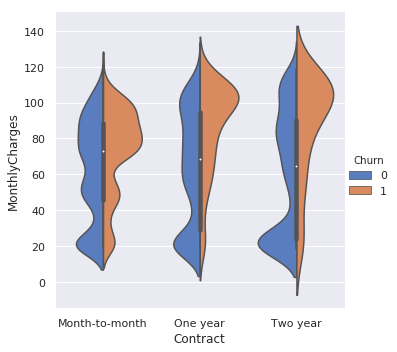

In [43]:
plt.figure(figsize=(7, 5))
sns.catplot(x='Contract', y='MonthlyCharges', data=data, hue='Churn', kind='violin', split=True);

<Figure size 504x360 with 0 Axes>

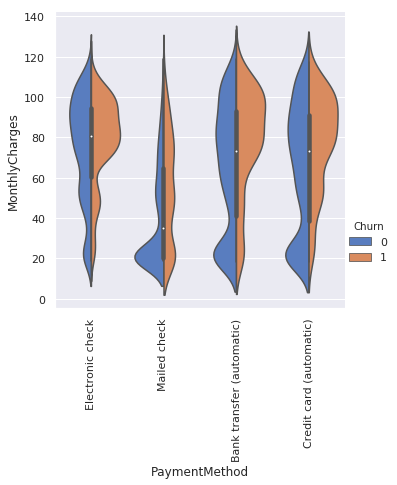

In [44]:
plt.figure(figsize=(7, 5))
sns.catplot(x='PaymentMethod', y='MonthlyCharges', data=data, hue='Churn', kind='violin', split=True)
plt.xticks(rotation=90);

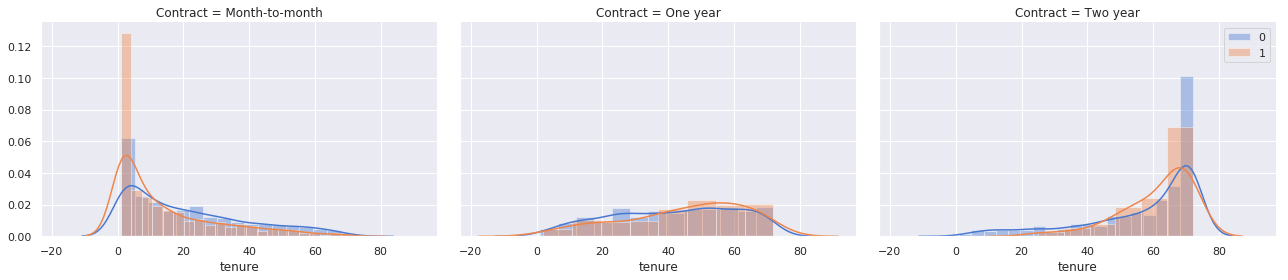

In [45]:
g = sns.FacetGrid(data=data, col='Contract', hue='Churn', height=4, aspect=1.5)
g.map(sns.distplot, 'tenure')
plt.legend();

Here we can see customer with monthly `Contract` have low `tenure` as with Two year contract have high tenure. With one year `Contract` `tenure` is almost uniformly distributed.

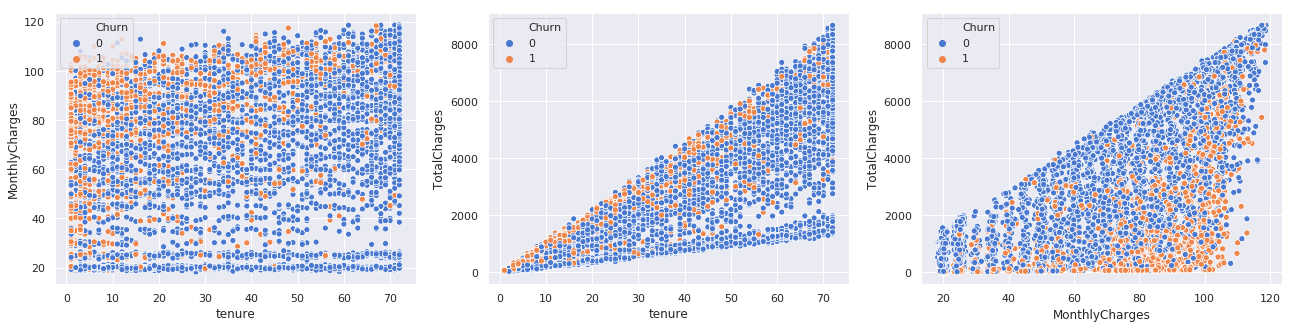

In [46]:
f, ax = plt.subplots(1, 3, figsize=(22, 5))
sns.scatterplot(x='tenure', y='MonthlyCharges', data=data, ax=ax[0], hue='Churn')
sns.scatterplot(x='tenure', y='TotalCharges', data=data, ax=ax[1], hue='Churn')
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', data=data, ax=ax[2], hue='Churn');

Let's bin the `tenure` and visualize it.

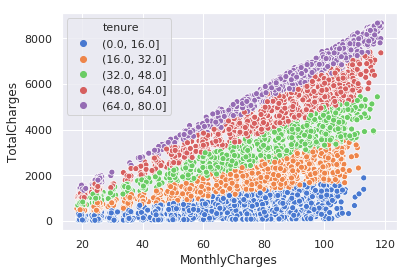

In [47]:
binned_tenure = pd.cut(data['tenure'], bins=np.linspace(0, 80, 6))
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', data=data, hue=binned_tenure);

Different types of `tenure` can be perfectly distinguished on the scatterplot.

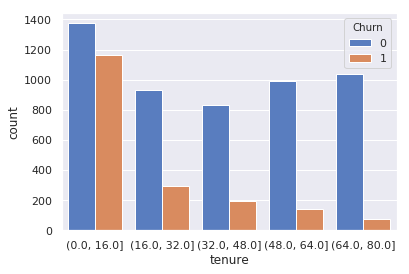

In [48]:
sns.countplot(binned_tenure, hue=data['Churn']);

Probability to churn decreases as tenure increases.

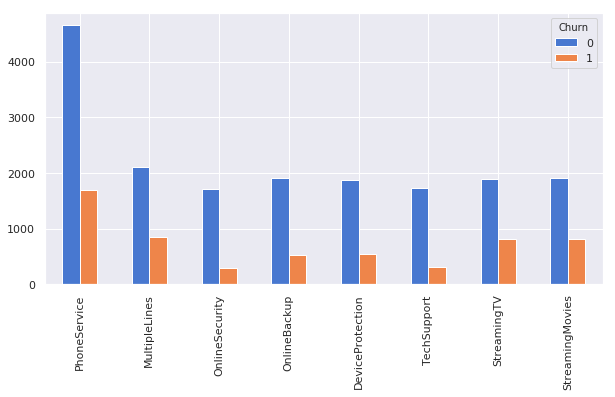

In [49]:
tmp = data.groupby('Churn')[opted_services].sum()
tmp.T.plot(kind='bar', figsize=(10, 5));

Let's count the services opted by the customer and visualize it.

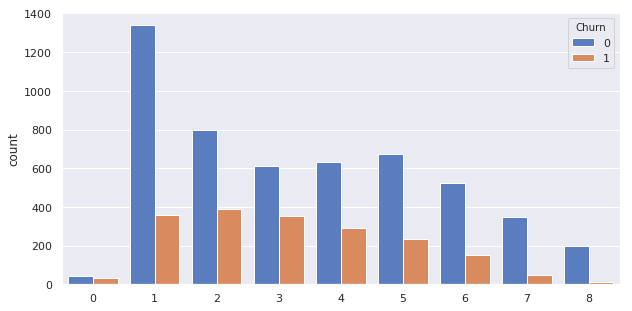

In [50]:
tmp = (data[opted_services] == 1).sum(axis=1)

plt.figure(figsize=(10, 5))
sns.countplot(tmp, hue=data['Churn']);

Increase in count of opted services decreses the churn probability.

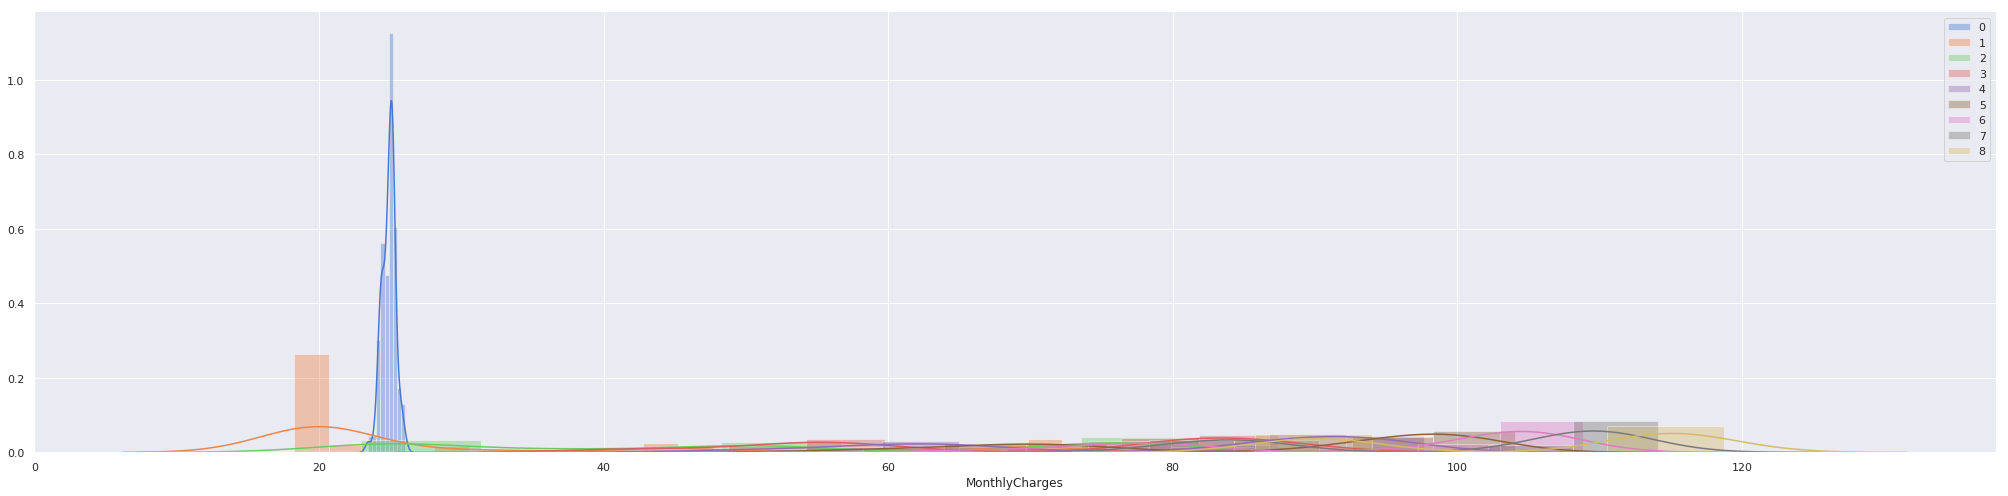

In [51]:
data['services_count'] = (data[opted_services] == 1).sum(axis=1)

g = sns.FacetGrid(data, hue='services_count', height=7, aspect=4)
g.map(sns.distplot, 'MonthlyCharges')
plt.legend();

We can see as the services increases monthly charges increases. Although it's not perfectly visible here but we can see bins of higher service count in the end.

### Data Manipulation

Let's create some new features. These features are created through cross validation and feature importances.

In [52]:
data['tenure_binned'] = pd.cut(data['tenure'], bins=np.linspace(0, 80, 6))
data['extra_charge'] = data['MonthlyCharges']*data['tenure'] - data['TotalCharges']

In [53]:
# Remove the target from data
target = data.pop('Churn')

# Get the names of binary features, categorical features and continious features.
bin_cols = [col for col in data.columns if data[col].nunique() == 2]
cat_cols = [col for col in data.columns if data[col].nunique() < 10]
cat_cols = list(set(cat_cols) - set(bin_cols))
cont_cols = list(set(data.columns) - set(cat_cols) - set(bin_cols))

# Let's label encode all the binary and categorical features.
for col in bin_cols + cat_cols:
    data[col] = (data[col].factorize()[0]).astype(np.int32)

Helper functions to scale and one-hot encode features. Scaling should be done before using a non-tree based model. Tree based models don't need features to be scaled because decision trees iterate over the values to make a split.

In [54]:
def scale_features(data, cols):
    data_cp = data.copy()
    data_cp[cols] = StandardScaler().fit_transform(data[cols])
    return data_cp

def one_hot(data, cols):
    return pd.get_dummies(data, columns=cols)

Let's scale and one-hot the features.

In [55]:
data_cp = scale_features(data, cont_cols)
data_cp = one_hot(data, cat_cols)

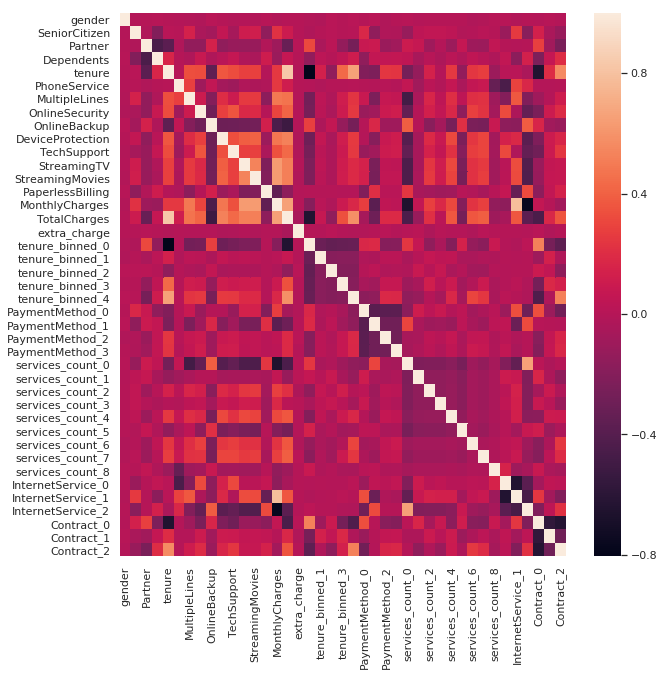

In [56]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_cp.corr());

We don's see too much correlation between features. Let's check if there are any columns with correlation > 0.9

In [57]:
corr_thres = 0.9

corr_matrix = data_cp.corr().abs()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > corr_thres)]
to_drop

[]

### Implement Machine Learning Models

**Choosing the metric**

Dataset is imbalanced and choosing the usual `accuracy` as the metric might get biased towards the majority class. So we will choose `Roc AUC` metric to get the tradeoff between True Positive Rate and False Positive Rate. Also just for convinience we will calculate `precision`, `recall` and `f1-score` too.

Helper function to plot confusion metric.

In [58]:
def plot_confusion_matrix(y_train, train_preds, y_valid, valid_preds):
    train_cm = confusion_matrix(y_train, train_preds)
    valid_cm = confusion_matrix(y_valid, valid_preds)
    
    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    for ax, cm, title in zip(axes, [train_cm, valid_cm], ['Train', 'Valid']):
        cm_df = pd.DataFrame(cm, columns=np.unique(y_train), index=np.unique(y_train))
        cm_df.index.name = 'Actual'
        cm_df.columns.name = 'Predicted'
        sns.set(font_scale=1.4)
        sns.heatmap(cm_df, cmap='Blues', annot=True, annot_kws={'size': 16}, ax=ax, fmt='g')
        ax.set_title(title)

Helper function to plot feature importance

In [59]:
def plot_feat_importance(cols, imp):
    sorted_ix = np.argsort(imp)[::-1]
    imp = imp[sorted_ix]
    sorted_cols = cols[sorted_ix]

    plt.figure(figsize=(7, 12))
    sns.barplot(x=imp, y=sorted_cols, orient='h')
    plt.title('Feature importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')

This helper function will calculate all the required metrics with the predictions from the model.

In [60]:
def get_metrics(model, X_train, y_train, X_valid, y_valid):
    train_preds, train_probs = model.predict(X_train), model.predict_proba(X_train)[:, 1]
    valid_preds, valid_probs = model.predict(X_valid), model.predict_proba(X_valid)[:, 1]
    
    train_scores = [accuracy_score(y_train, train_preds), roc_auc_score(y_train, train_probs),
                    precision_score(y_train, train_preds), recall_score(y_train, train_preds),
                    f1_score(y_train, train_preds)]
    
    valid_scores = [accuracy_score(y_valid, valid_preds), roc_auc_score(y_valid, valid_probs),
                    precision_score(y_valid, valid_preds), recall_score(y_valid, valid_preds),
                    f1_score(y_valid, valid_preds)]
    
    
    scores = pd.DataFrame({
        'train': train_scores,
        'valid': valid_scores
    }, index=['accuracy', 'roc_auc', 'precision', 'recall', 'f1_score'])
    
    plot_confusion_matrix(y_train, train_preds, y_valid, valid_preds)
    return scores

Helper function to perform **Grid Search**.

In [61]:
def do_grid_search(model, params, train_X, train_y):
    skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
    grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=skf, verbose=0, n_jobs=-1)
    grid_search.fit(train_X, train_y)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    return grid_search

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(data_cp, target, test_size=0.2, stratify=target, random_state=SEED)

#### Logistic Regression

,train,valid
accuracy,0.803911,0.810235
roc_auc,0.848912,0.857972
precision,0.664983,0.680135
recall,0.528428,0.540107
f1_score,0.588893,0.602086


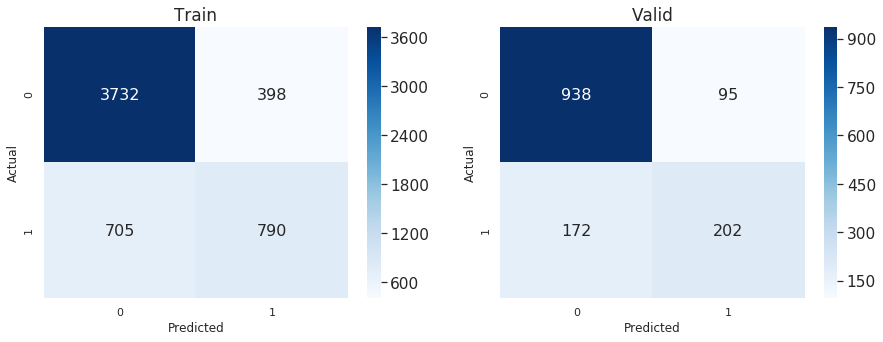

In [63]:
model = LogisticRegression(random_state=SEED, n_jobs=-1, penalty='l1')
model.fit(X_train, y_train)
get_metrics(model, X_train, y_train, X_valid, y_valid)

Grid Search with Logistic Regression

0.8467332674560216
{'C': 0.30000000000000004}


,train,valid
accuracy,0.804800,0.812367
roc_auc,0.848330,0.860607
precision,0.665831,0.683333
recall,0.533110,0.548128
f1_score,0.592125,0.608309


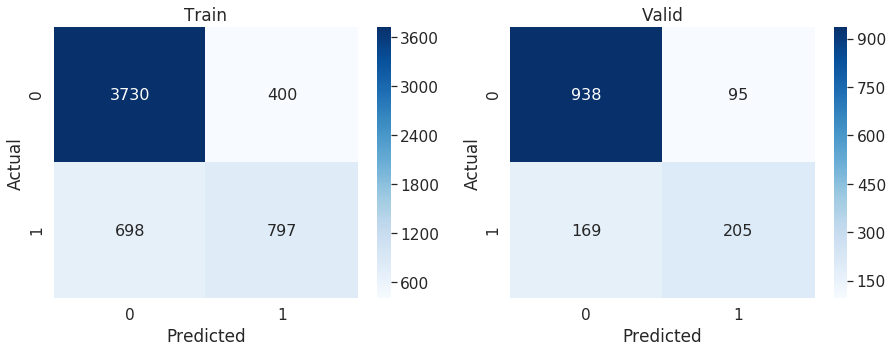

In [64]:
param_grid = {'C': np.linspace(0.02, 3, 150)}
grid_search_model = do_grid_search(model, param_grid, data_cp, target)
get_metrics(grid_search_model, X_train, y_train, X_valid, y_valid)

Here we can see we have more false-negatives as compared to false-positives.

#### Support vector machine

,train,valid
accuracy,0.750400,0.759773
roc_auc,0.952814,0.705986
precision,0.603645,0.660714
recall,0.177258,0.197861
f1_score,0.274043,0.304527


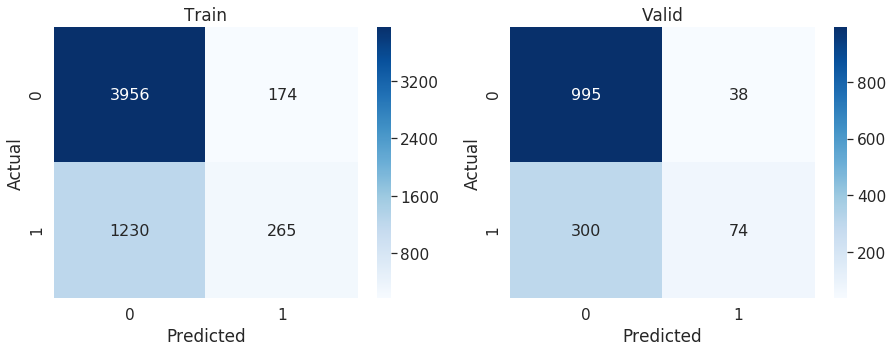

In [65]:
model = SVC(C=0.05, random_state=SEED, probability=True, class_weight='balanced')
model.fit(X_train, y_train)
get_metrics(model, X_train, y_train, X_valid, y_valid)

SVC overfitted on training set and gave more false negatives as compared to false positives.

#### Random Forest

,train,valid
accuracy,0.998578,0.805259
roc_auc,0.999890,0.851371
precision,0.995336,0.685185
recall,0.999331,0.494652
f1_score,0.997330,0.574534


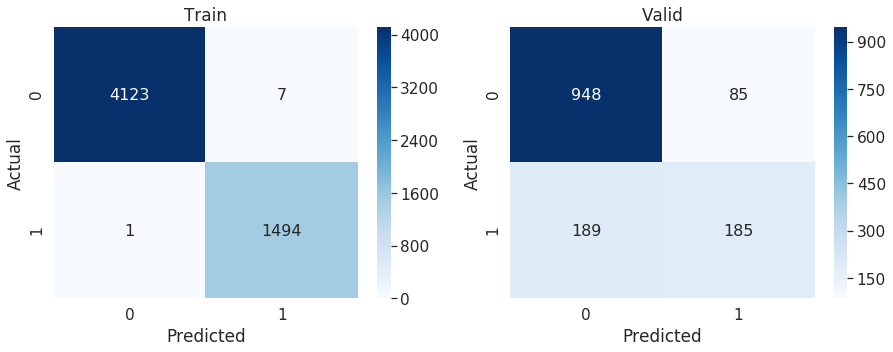

In [66]:
model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=SEED, n_jobs=-1)
model.fit(X_train, y_train)
get_metrics(model, X_train, y_train, X_valid, y_valid)

Grid Search with RandomForest

0.8467178037250161
{'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 2}


,train,valid
accuracy,0.774400,0.776830
roc_auc,0.876113,0.890422
precision,0.550133,0.553191
recall,0.829431,0.834225
f1_score,0.661510,0.665245


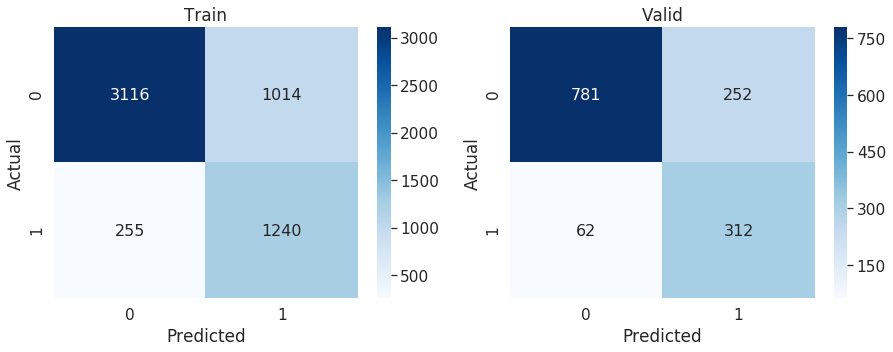

In [67]:
param_grid = {
    'min_samples_split': [2, 5],
    'max_features': ['auto', 0.7, 1.],
    'max_depth': [5, 7, 10]
}

grid_search_model = do_grid_search(model, param_grid, data_cp, target)
get_metrics(grid_search_model, X_train, y_train, X_valid, y_valid)

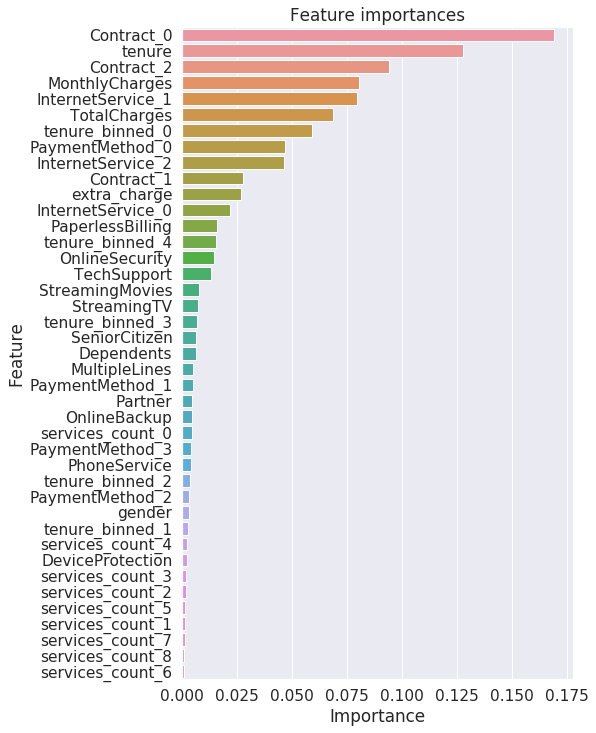

In [68]:
plot_feat_importance(cols=X_train.columns.values, imp=grid_search_model.best_estimator_.feature_importances_)

RandomForest performed better than LogisticRegression and SVM. Here we have more false positives as compared to false negatives which is better than the above case in case of churn prediction.

#### LightGBM

,train,valid
accuracy,0.815822,0.820896
roc_auc,0.874859,0.859963
precision,0.700787,0.711806
recall,0.535786,0.548128
f1_score,0.607278,0.619335


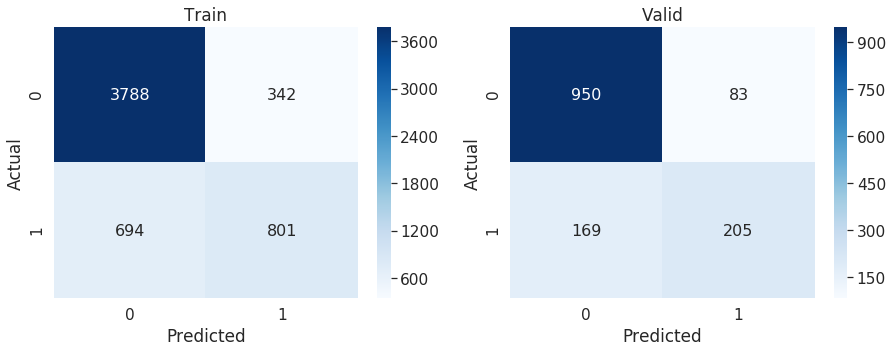

In [69]:
model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.0027825594022071257,
    max_depth=5,
    num_leaves=20,
    random_state=SEED,
    n_jobs=1
)

model.fit(X_train, y_train)
get_metrics(model, X_train, y_train, X_valid, y_valid)

Grid Search with LightGBM

0.8457076439486017
{'colsample_by_tree': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.01, 'subsample': 0.5}


,train,valid
accuracy,0.814400,0.830846
roc_auc,0.868744,0.883197
precision,0.699734,0.731293
recall,0.528428,0.574866
f1_score,0.602134,0.643713


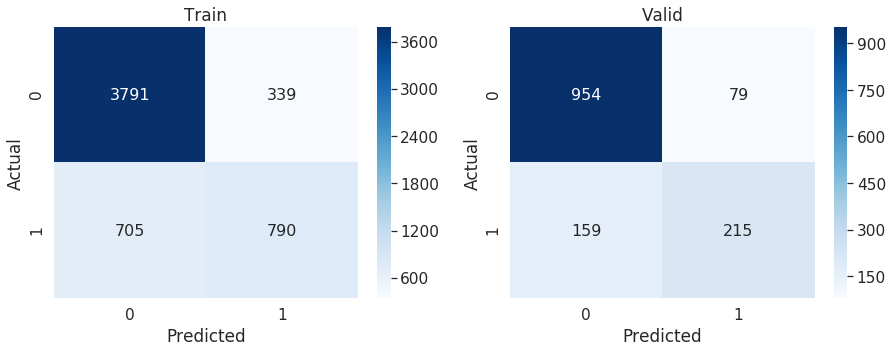

In [70]:
param_grid = {
    'subsample': [0.5, 0.7, 1.],
    'colsample_by_tree': [0.5, 0.7, 1],
    'reg_lambda': [0.01, 0.1, 1, 10],
    'reg_alpha': [0.01, 0.1, 1, 10]
}

grid_search_model = do_grid_search(model, param_grid, data_cp, target)
get_metrics(grid_search_model, X_train, y_train, X_valid, y_valid)

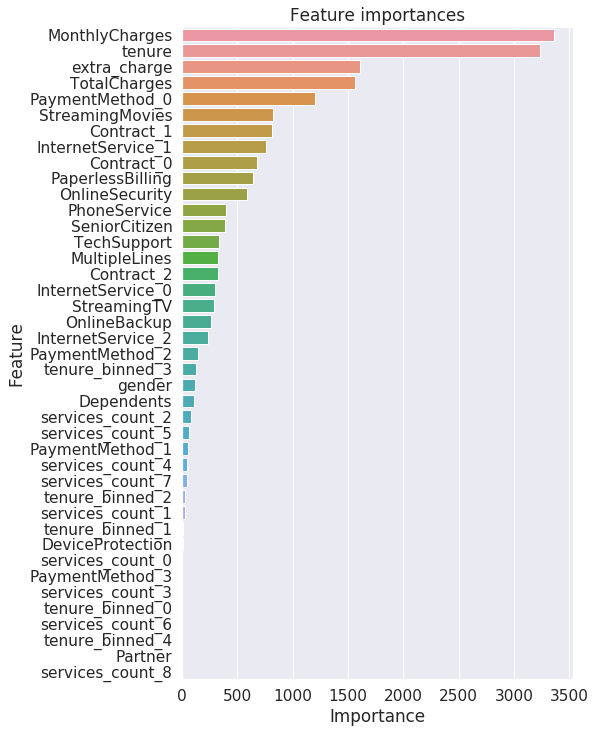

In [71]:
plot_feat_importance(cols=X_train.columns.values, imp=grid_search_model.best_estimator_.feature_importances_)

#### CatBoost

CatBoost handles categorical columns automatically using target_encoding + prior_regularization so we don't need to one-hot encode the categorical columns.

**NOTE**: CatBoost was taking a lot of time so hyper-parameters are already tuned for catboost through cross validation.

In [75]:
data_cp = data.copy()
cat_features = bin_cols + cat_cols

X_train, X_valid, y_train, y_valid = train_test_split(data_cp, target, test_size=0.2, stratify=target, random_state=SEED)

,train,valid
accuracy,0.832889,0.773276
roc_auc,0.924519,0.859610
precision,0.630711,0.553191
recall,0.895652,0.764706
f1_score,0.740188,0.641975


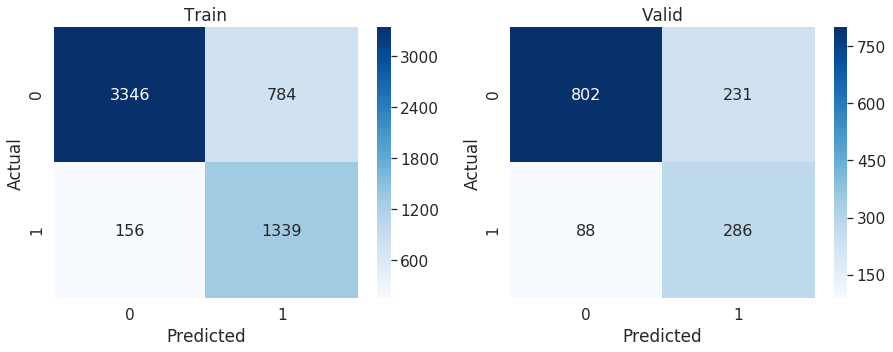

In [76]:
model = cb.CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    depth=7,
    colsample_bylevel=0.5,
    class_weights=[1., 2.76],
    bootstrap_type='Bernoulli',
    random_state=SEED,
    thread_count=-1,
    verbose=0,
    cat_features=cat_features
)

model.fit(X_train, y_train)
get_metrics(model, X_train, y_train, X_valid, y_valid)

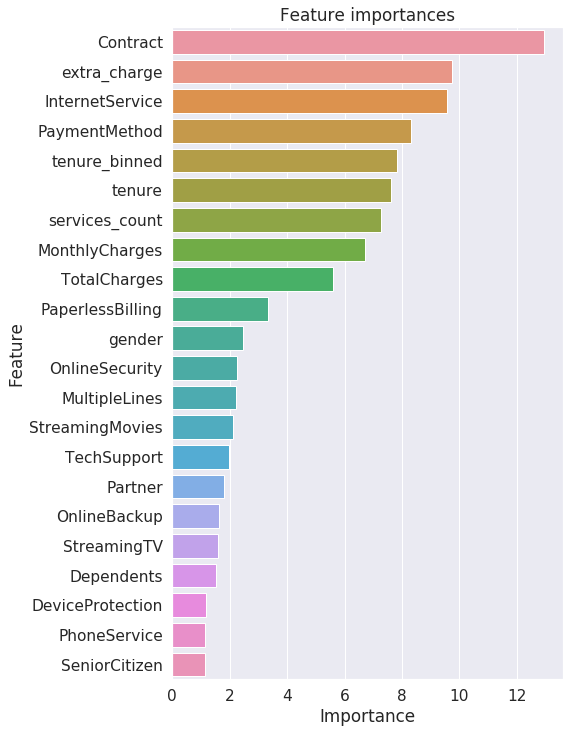

In [77]:
plot_feat_importance(cols=X_train.columns.values, imp=model.feature_importances_)

Some of the features we created such as `extra_charge`, `tenure_binned` and `services_count` have higher feature_importane and same can be concluded from the plots we made.

#### What offers should be made to which customers to encourage them to remain with company?
- Services such as `OnlineSecurity`, 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies' reduces the churn probability.
- Customers with yearly plan tends to have lower churn probability so company can take steps to outreach customers with yearly offers.